In [1]:
import glob
import pandas as pd
import numpy as np

In [2]:
real1_folder = "results/real_1"
real2_folder = "results/real_2"

In [3]:
setting_map = {
    "codebert": "codebert.csv",
    "graphcodebert": "graphcodebert.csv",
    "unixcoder": "unixcoder.csv",
    "ggnn": "ggnn.csv",
    "great": "great.csv",
}

In [4]:
def relative_performance(df, settings = ("codebert", "graphcodebert", "unixcoder", "ggnn", "great", "transformer")):
    records = df.to_dict("records")
    settings_map = set(settings)
    base_map = dict()
    for record in records:
        if record["setup"] in settings_map:
            base_map[record["setup"]] = record

    results = []
    for record in records:
        if record["setup"] in settings_map:
            continue
        name = record["setup"].split(" ")[0]
        if name not in base_map:
            print(f"Warning: missing base performance for {name}")
            continue

        base_performance = base_map[name]
        result = {"setup": record["setup"]}
        for key in record.keys():
            if key == "setup":
                continue
            result[key] = (record[key] - base_performance[key])
        results.append(result)
    return pd.DataFrame(results)

In [5]:
def measure_result_classification_pipeline(df, sample_weight=1, beta=1):
    df["gt_label"] = df["gt_error_loc"] > 0
    df["pred_label"] = (df["loc_pred"] == df["gt_error_loc"]) & (df["gt_label"])
    df["sample_weight"] = sample_weight * df["gt_label"] + (~df["gt_label"])

    tp = ((df["loc_pred"] == df["gt_error_loc"]) | df["type_check_failed"]) & (df["gt_label"])
    tp = (tp * df["sample_weight"]).sum()
    tn = ((df["loc_pred"] == 0) & (~df["type_check_failed"])) & (~df["gt_label"])
    tn = (tn * df["sample_weight"]).sum()
    pp = (df["loc_pred"] > 0) | df["type_check_failed"]
    pp = (pp * df["sample_weight"]).sum()
    fp = pp - tp
    fn = ((df["loc_pred"] == 0) & (~df["type_check_failed"])) & (df["gt_label"])
    fn = (fn * df["sample_weight"]).sum()

    # print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    csi = tp / (tp + fn + fp)

    fb = (1 + beta ** 2) * precision * recall / (beta ** 2 * precision + recall)

    return precision, recall, fb

In [6]:
def measure_result_classification(df, type_check_failed=False, typecheck=True, sample_weight=1, beta=1):
    if typecheck:
        df = df[df['type_check_failed'] == type_check_failed]


    df["gt_label"] = df["gt_error_loc"] > 0
    df["pred_label"] = (df["loc_pred"] == df["gt_error_loc"]) & (df["gt_label"])
    df["sample_weight"] = sample_weight * df["gt_label"] + (~df["gt_label"])
    

    tp = (df["loc_pred"] == df["gt_error_loc"]) & (df["gt_label"])
    tp = (tp * df["sample_weight"]).sum()
    tn = (df["loc_pred"] == 0) & (~df["gt_label"])
    tn = (tn * df["sample_weight"]).sum()
    pp = df["loc_pred"] > 0
    pp = (pp * df["sample_weight"]).sum()
    fp = pp - tp
    fn = (df["loc_pred"] == 0) & (df["gt_label"])
    fn = (fn * df["sample_weight"]).sum()

    # print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    csi = tp / (tp + fn + fp)

    fb = (1 + beta ** 2) * precision * recall / (beta ** 2 * precision + recall)


    return precision, recall, fb

def reset_sample_ids(df, end_idx=1291):
    if "sample_id" not in df.columns:
        return df
    df_bugs = df[df["gt_error_loc"] > 0]
    df_no_bugs = df[df["gt_error_loc"] == 0]

    records = df_no_bugs.to_dict("records")
    for i, record in enumerate(records):
        record["sample_id"] = i + end_idx

    return pd.concat([df_bugs, pd.DataFrame(records)])

In [7]:
def precess_df(folder, filename, leak_max_idx=None, reset_sample_id=False):
    type_files = glob.glob(f"{folder}/typechecking_pipeline/*.csv")

    type_check_df = pd.concat([pd.read_csv(file) for file in type_files])
    type_check_df = type_check_df.reset_index()

    test_leak = pd.read_csv(f"{folder}/test_leak.csv", index_col=0)
    if leak_max_idx:
        test_leak = test_leak.iloc[:leak_max_idx]

    ground_truth_df = pd.read_csv(f"{folder}/ground_truth.csv")
    df = pd.read_csv(f"{folder}/{filename}")
    if reset_sample_id:
        df = reset_sample_ids(df, end_idx=leak_max_idx)

    if "sample_id" in df.columns:
        df = df.set_index("sample_id")
    elif "sample_ids" in df.columns:
        df = df.set_index("sample_ids")
    df = df.drop(columns=["gt_error_loc"])
    df = df.join(ground_truth_df)
    df = df.join(test_leak)

    df = df.fillna(False)
    df = df[df["leaked"] == False]
    df = df.join(type_check_df)
    df.fillna(False, inplace=True)
    
    return df

In [8]:
filename = setting_map["codebert"]
df_real1 = precess_df(real1_folder, filename, leak_max_idx=1292, reset_sample_id=True)  # 1292 faulty programs, correct programs are already filtered

df_real2 = precess_df(real2_folder, filename)

df =  pd.concat([df_real1, df_real2])

print(len(df_real2))

type_check_precision = (df["type_check_failed"] & (df["gt_error_loc"] > 0)).sum() / df["type_check_failed"].sum()
type_check_recall = (df["type_check_failed"] & (df["gt_error_loc"] > 0)).sum() / (df["gt_error_loc"] > 0).sum()


print(f"type check precision: {type_check_precision}, recall: {type_check_recall}")
    

1046
type check precision: 0.17834394904458598, recall: 0.05008944543828265


In [9]:
beta = 1.5
results = []
for key, filename in setting_map.items():
    df_real1 = precess_df(real1_folder, filename, leak_max_idx=1292, reset_sample_id=True)  # 1292 faulty programs, correct programs are already filtered

    df_real2 = precess_df(real2_folder, filename)

    df =  pd.concat([df_real1, df_real2])
    df = df.reset_index()
    metrics = measure_result_classification(df, typecheck=False, beta=beta)
    metrics_pipeline = measure_result_classification_pipeline(df, beta=beta)
    
    results.append({
        "setup": key,
        "precision": metrics[0] * 100,
        "pipeline_precision": metrics_pipeline[0] * 100,
        "precision_delta": (metrics_pipeline[0] - metrics[0]) * 100,
        "recall": metrics[1] * 100,
        "pipeline_recall": metrics_pipeline[1] * 100,
        "recall_delta": (metrics_pipeline[1] - metrics[1]) * 100,
        "fb": metrics[2] * 100,
        "pipeline_fb": metrics_pipeline[2] * 100,
        "fb_delta": (metrics_pipeline[2] - metrics[2]) * 100,
    })

In [10]:
pd.DataFrame(results) 

,setup,precision,pipeline_precision,precision_delta,recall,pipeline_recall,recall_delta,fb,pipeline_fb,fb_delta
0,codebert,27.996575,25.225538,-2.771038,32.264430,35.584924,3.320494,30.818864,31.592846,0.773982
1,graphcodebert,30.840259,27.132353,-3.707906,32.585366,35.807860,3.222494,32.027735,32.600496,0.572761
2,unixcoder,31.846847,27.984133,-3.862714,34.555230,37.688198,3.132968,33.674068,34.054620,0.380552
3,ggnn,10.512129,11.314286,0.802156,17.294900,21.806167,4.511267,14.430056,16.965463,2.535407
4,great,9.921437,10.348319,0.426883,26.690821,30.489260,3.798439,17.558978,19.069354,1.510375


In [11]:
print(pd.DataFrame(results).round(2).to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
         setup &  precision &  pipeline\_precision &  precision\_delta &  recall &  pipeline\_recall &  recall\_delta &     fb &  pipeline\_fb &  fb\_delta \\
\midrule
      codebert &      28.00 &               25.23 &            -2.77 &   32.26 &            35.58 &          3.32 &  30.82 &        31.59 &      0.77 \\
 graphcodebert &      30.84 &               27.13 &            -3.71 &   32.59 &            35.81 &          3.22 &  32.03 &        32.60 &      0.57 \\
     unixcoder &      31.85 &               27.98 &            -3.86 &   34.56 &            37.69 &          3.13 &  33.67 &        34.05 &      0.38 \\
          ggnn &      10.51 &               11.31 &             0.80 &   17.29 &            21.81 &          4.51 &  14.43 &        16.97 &      2.54 \\
         great &       9.92 &               10.35 &             0.43 &   26.69 &            30.49 &          3.80 &  17.56 &        19.07 &      1.51 \\
\bottomrule
\end{tabular}



In [12]:
def calculate_fb(df, betas):
    results = []
    pipeline_results = []
    for beta in betas:
        metrics = measure_result_classification(df, typecheck=False, beta=beta)
        metrics_pipeline = measure_result_classification_pipeline(df, beta=beta)

        results.append(metrics[2])
        pipeline_results.append(metrics_pipeline[2])
    
    return results, pipeline_results
        

In [13]:
betas = np.linspace(0.5, 3, 26)


In [14]:
results = {}

for key, filename in setting_map.items():
    df_real1 = precess_df(real1_folder, filename, leak_max_idx=1292)  # 1292 faulty programs, correct programs are already filtered
    df_real2 = precess_df(real2_folder, filename)

    df =  pd.concat([df_real1, df_real2])

    results[key] = calculate_fb(df, betas)

In [15]:
from intersect import intersection
intersection(betas, results["unixcoder"][0], betas, results["unixcoder"][1])

(array([1.34337376]), array([0.33536977]))

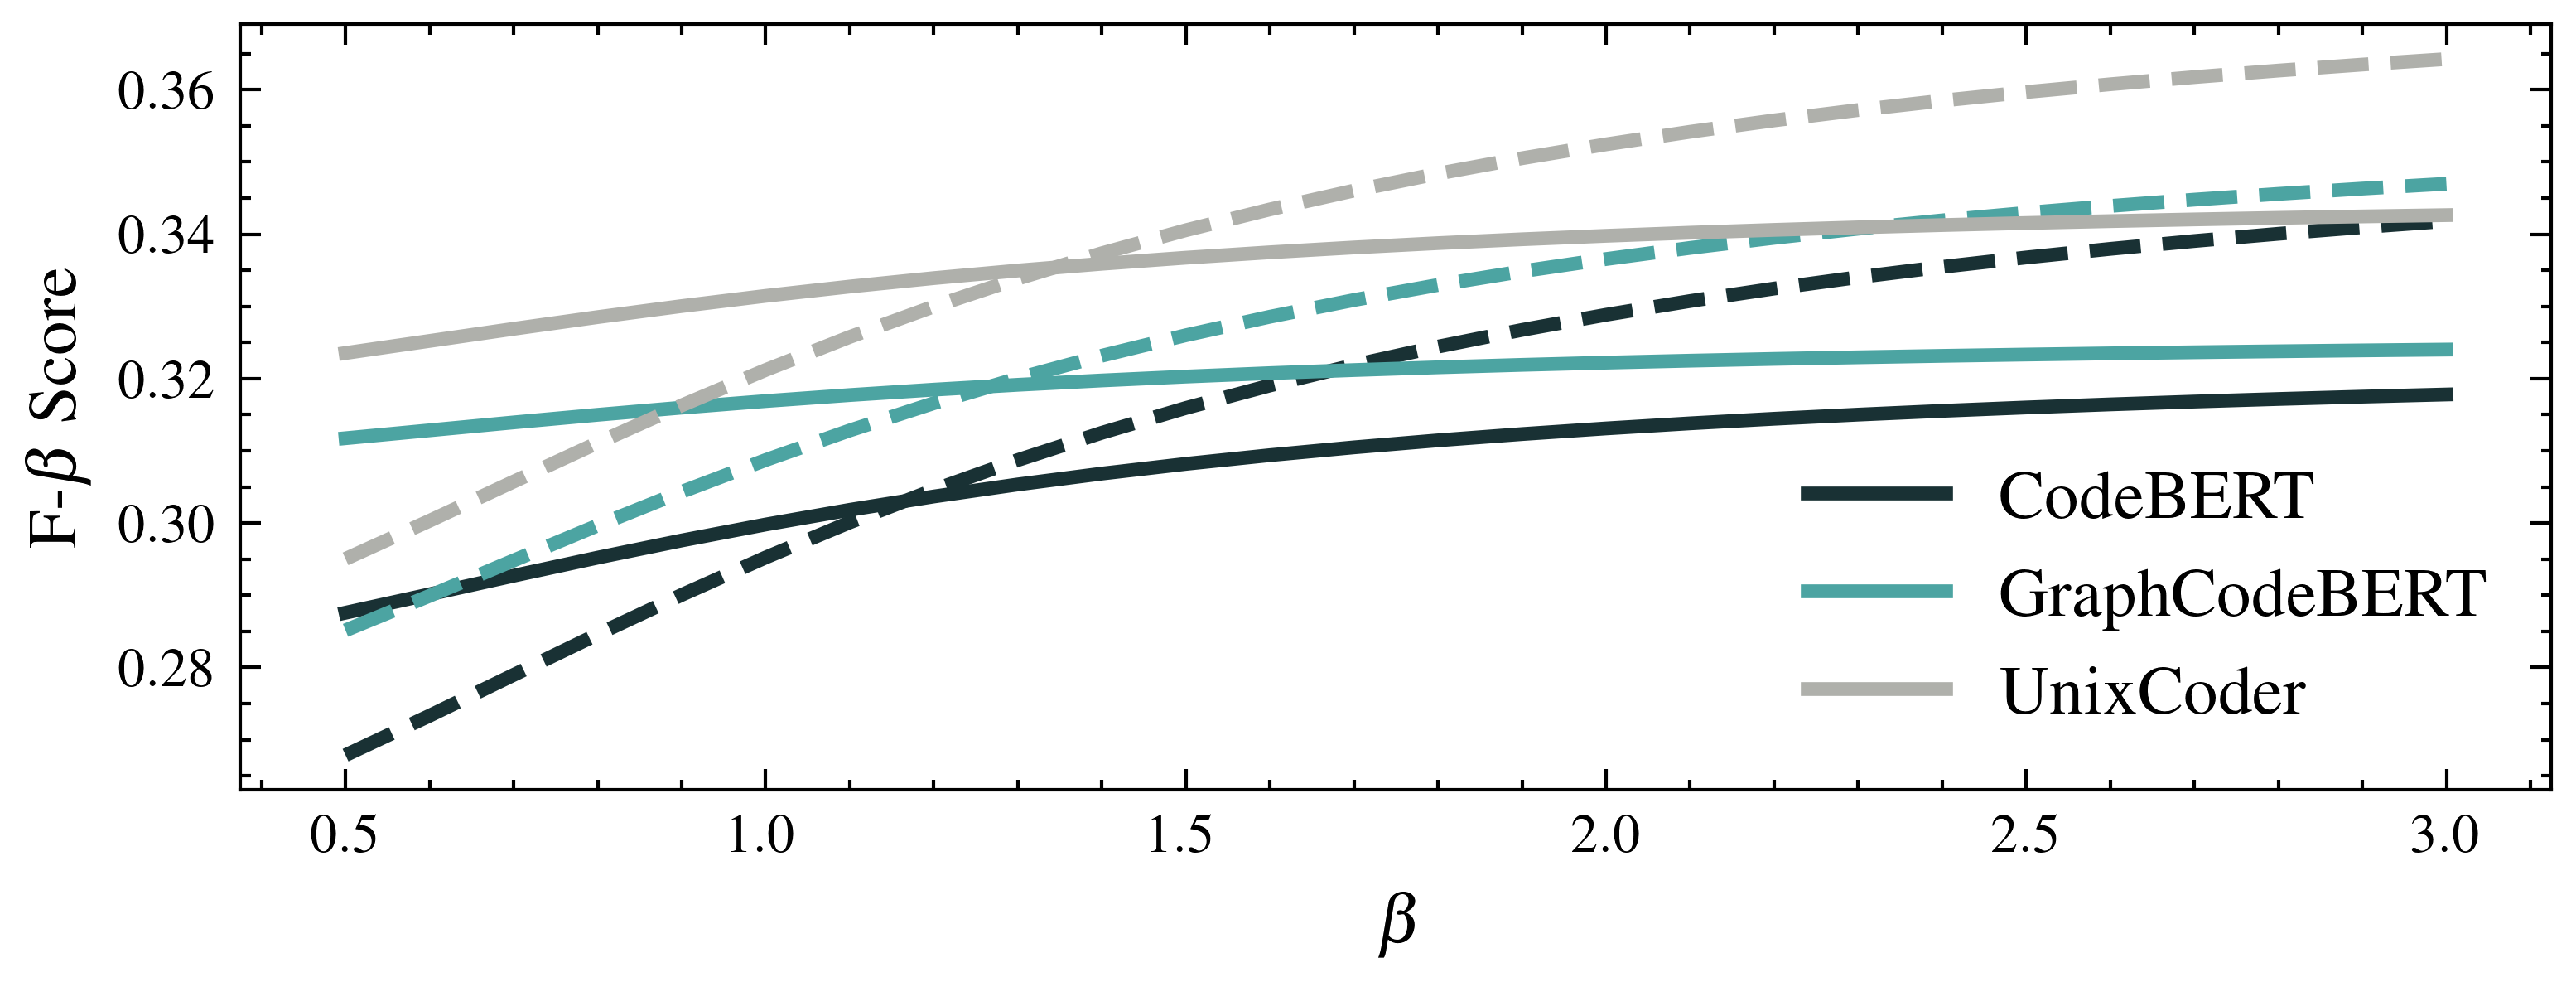

In [32]:
# plot results, show all lines on the same figure
import matplotlib.pyplot as plt
import scienceplots
import matplotlib
# matplotlib.use('pgf')
plt.style.use(['science','ieee'])

plt.figure(figsize=(6, 2))
# set font size
plt.rcParams.update({'font.size': 8})
# set font size on the axes
plt.rcParams.update({'axes.labelsize': 10})
# set font size for the legend
plt.rcParams.update({'legend.fontsize': 10})

settings = ["codebert", "graphcodebert", "unixcoder"]
names = ["CodeBERT", "GraphCodeBERT", "UnixCoder"]
colors = [(25, 49, 52), (76, 164, 162), (175, 176, 171)]

for i, setting in enumerate(settings):
    plt.plot(betas, results[setting][0], linewidth=2, linestyle="-", label=names[i], color=np.array(colors[settings.index(setting)])/255)
    plt.plot(betas, results[setting][1], linewidth=2, linestyle="--", color=np.array(colors[settings.index(setting)])/255)

plt.xlabel("$\\beta$")
plt.ylabel("F-$\\beta$ Score")

plt.legend()
plt.savefig("fbeta_score.pdf")
plt.show()


## Manual Annotation

In [17]:
from utils import get_performance
import pandas as pd
from tqdm import tqdm

In [18]:
def print_pipeline_rows(result):
    nn_precision, nn_recall, _ = result["original_performance"]
    pipeline_precision, pipeline_recall, _ = result["original_pipeline_performance"]
    pytype_precision, pytype_recall, _ = result["new_pipeline_performance"]
    mypy_precision, mypy_recall, _ = result["new_pipeline_performance_mypy"]

    # print(f"""{nn_precision * 100:.2f} & {pipeline_precision * 100:.2f} & {pytype_precision * 100:.2f} & {mypy_precision * 100:.2f} & {nn_recall * 100:.2f} & {pipeline_recall * 100:.2f} & {pytype_recall * 100:.2f} & {mypy_recall * 100:.2f}""")
    return nn_precision, pipeline_precision, pytype_precision, mypy_precision, nn_recall, pipeline_recall, pytype_recall, mypy_recall

In [19]:
result = get_performance("codebert")

print("Original Pytype performance")
print(f"Precision: {result['original_pytype'][0]}, Recall: {result['original_pytype'][1]}")
print("pytype performance")
print(f"Precision: {result['pytype'][0]}, Recall: {result['pytype'][1]}")
print("mypy performance")
print(f"Precision: {result['mypy'][0]}, Recall: {result['mypy'][1]}")

Original Pytype performance
Precision: 0.5, Recall: 0.015
pytype performance
Precision: 0.9090909090909091, Recall: 0.15
mypy performance
Precision: 0.8780487804878049, Recall: 0.18


In [20]:
models = ["codebert", "graphcodebert", "unixcoder", "ggnn", "great"]
results = []

for model in tqdm(models):
    result = get_performance(model)
    nn_precision, pipeline_precision, pytype_precision, mypy_precision, nn_recall, pipeline_recall, pytype_recall, mypy_recall = print_pipeline_rows(result)

    results.append({
        "setup": model,
        "nn_precision":  nn_precision * 100,
        "pipeline_precision": pipeline_precision * 100,
        "pytype_precision": pytype_precision * 100,
        "mypy_precision": mypy_precision * 100,
        "nn_recall": nn_recall * 100,
        "pipeline_recall": pipeline_recall * 100,
        "pytype_recall": pytype_recall * 100,
        "mypy_recall": mypy_recall * 100,
    })


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:50<00:00, 10.05s/it]


In [21]:
pd.DataFrame(results).round(2)

,setup,nn_precision,pipeline_precision,pytype_precision,mypy_precision,nn_recall,pipeline_recall,pytype_recall,mypy_recall
0,codebert,74.49,72.55,75.65,74.79,39.25,39.78,46.77,47.85
1,graphcodebert,72.00,69.90,73.50,73.77,39.78,39.78,47.51,49.45
2,unixcoder,76.24,75.00,78.63,77.05,41.62,41.94,49.20,50.54
3,ggnn,46.58,46.75,59.34,59.79,19.88,20.93,30.68,32.95
4,great,39.60,38.46,50.43,51.64,24.24,24.24,34.50,36.84
